In [0]:
2+2

4

In [0]:
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# import tensorflow as tf
# hello = tf.constant('Hello, TensorFlow!')
# sess = tf.Session()
# print(sess.run(hello))

Num GPUs Available:  1


In [0]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#     except RuntimeError as e:
#         # Visible devices must be set before GPUs have been initialized
#         print(e)

In [0]:
#conda install gensim or pip install gensim
import pandas as pd

#import re
#import nltk
#from nltk.tokenize import word_tokenize
#from nltk.tokenize import TweetTokenizer
#tknzr = TweetTokenizer()
#from nltk.corpus import stopwords
#import itertools
#import functools
import gensim
# from functools import reduce
# nltk.download('gutenberg')
# from nltk.corpus import gutenberg
# from nltk.sentiment import SentimentAnalyzer
# nltk.download('vader_lexicon')
# import numpy as np
# from scipy import spatial
# import re
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_recall_fscore_support
# from sklearn import svm
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report
# from sklearn.multiclass import OneVsRestClassifier
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import keras

In [0]:
import pandas as pd
pd.set_option("display.max_rows", 999)
pd.set_option('max_colwidth',100)
import numpy as np
from IPython.display import display

In [0]:
# filepath = "./emailData/emails.csv"
# # Read the data into a pandas dataframe called emails
# emails = pd.read_csv(filepath)
# headers = [header for header in emails.columns]
# print("Successfully loaded {} rows and {} columns!".format(emails.shape[0], emails.shape[1]))
# print(display(emails.head()))

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# import keras

In [0]:
#print(emails.loc[0]["message"])

In [0]:
# import email

# def insert_value(dictionary, key, value):
#     if key in dictionary:
#         values = dictionary.get(key)
#         values.append(value)
#         dictionary[key] = values
#     else:
#         dictionary[key] = [value]
#     return dictionary

# def get_headers(df, header_names):
#     headers = {}
#     messages = df["message"]
#     for message in messages:
#         e = email.message_from_string(message)
#         for item in header_names:
#             header = e.get(item)
#             insert_value(dictionary = headers, key = item, value = header) 
#     print("Successfully retrieved header information!")
#     return headers
# header_names = ["Date", "Subject", "X-Folder", "X-From", "X-To"]    
# headers = get_headers(emails, header_names)

In [0]:
# def get_messages(df):
#     messages = []
#     for item in df["message"]:
#         # Return a message object structure from a string
#         e = email.message_from_string(item)    
#         # get message body  
#         message_body = e.get_payload()
#         message_body = message_body.lower()
#         messages.append(message_body)
#     print("Successfully retrieved message body from e-mails!")
#     return messages
# msg_body = get_messages(emails)
# emails["Message-Body"] = msg_body

In [0]:
# emails["Message-Body"].head(10)

In [0]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2019-11-30 19:29:57--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.164.189
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.164.189|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [0]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format('/root/input/GoogleNews-vectors-negative300.bin.gz', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
import tensorflow as tf

In [0]:
# from tensorflow.keras import backend as K
# K._get_available_gpus()

In [0]:
vocab = set()

In [0]:
# def processText(text):
    
#     sentences = nltk.sent_tokenize(text)
#     tokens = []
        
#     for sentence in sentences:
        
#         #Remove URL
#         sentence = re.sub(r"http\S+", "", sentence)
        
#         #words = nltk.word_tokenize(sentence)
#         words = tknzr.tokenize(sentence)
#         #Converting to LowerCase
#         words = map(str.lower, words)
    
#         words = map(lambda x: re.sub(r'[^a-zA-Z]', "", x), words)
        
#         #punctuations = '"#$%&\'()*+,-/:;<=>@[\\]^_`{|}~.?!'
#         #words = map(lambda x: x.translate(str.maketrans('', '', punctuations)), words)
        
#         # Remove empty strings
#         words = filter(lambda x: len(x) > 0, words)
        
#         #Remove words which are not part of word2vec vocab
#         words = filter(lambda x: x in word2vec.vocab, words)
        
#         words = list(words)
        
#         #Add the words to the vocabulary
#         vocab.update(words)
        
#         # Adding the preprocessed words to the document
#         tokens = tokens + words
        
#     return tokens

In [0]:
# emails['message_tokens'] = emails['Message-Body'].apply(lambda x: processText(x))

In [0]:
# emails['message_tokens'].head()

In [0]:
# emails.to_pickle('./emailDf')

In [0]:
#emailsdf['message_tokens'].to_pickle('./emailTokens')

In [0]:
#emailsdf = pd.read_pickle('./emailDf')

In [0]:
from tensorflow.keras import backend as K
#from keras import backend as K
def perplexity(y_true, y_pred):
    cross_entropy = K.categorical_crossentropy(y_true, y_pred)
    return K.pow(2.0, cross_entropy)

In [0]:
emailTokens = pd.read_pickle('drive/My Drive/Next Word Prediction/emailTokens')

In [0]:
emailTokens.head()

0                                                                              [here, is, our, forecast]
1    [traveling, have, business, meeting, takes, the, fun, out, the, trip, especially, if, you, have,...
2                                                                            [test, successful, way, go]
3    [randy, can, you, send, me, schedule, the, salary, level, everyone, in, the, scheduling, group, ...
4                                                                        [lets, shoot, for, tuesday, at]
Name: message_tokens, dtype: object

In [0]:
#emailsdf['message_tokens'].head()

In [0]:
import ast

In [0]:
# with open('vocab.txt','w') as f:
#     f.write(str(vocab))

In [0]:
with open('drive/My Drive/Next Word Prediction/vocab.txt','r') as f:
    vocab = ast.literal_eval(f.read())

In [0]:
#Convert vocab set to a dictionary
word_map = dict()
inverse_word_map = dict()
i = 1
for x in vocab:
    word_map[x] = i
    inverse_word_map[i] = x
    i+=1

In [0]:
word_map[''] = 0
inverse_word_map[0] = ''

In [0]:
vocab.add('')

In [0]:
seq_len = 5

In [0]:
import copy

In [0]:
#test = test.iloc[1:1000]

In [0]:
from tqdm import tqdm

In [0]:
def makeSequences(test):
    sequences = list()
    number_sequence = list()
    w2v_sequence = list()

    for sentence in test:
        for i in range(seq_len):
            sentence.insert(0,'')
        for i in range(seq_len,len(sentence)):
            sequence = sentence[i-seq_len:i+1]
            sequences.append(sequence)
            seq_i = list()
            seq_w2v = list()
            for word in sequence:
                seq_i.append(word_map[word])
                if(word == ""):
                    seq_w2v.append(np.zeros(300))
                else:
                    seq_w2v.append(word2vec[word])
            number_sequence.append(seq_i)
            w2v_sequence.append(seq_w2v)
    return (sequences,number_sequence,w2v_sequence)

In [0]:
def makeSequencestest(test):
    sequences = list()
    number_sequence = list()
    w2v_sequence = list()
    sentences = list()
    for sentence in test:
        for i in range(seq_len):
            sentence.insert(0,'')
        for i in range(seq_len,len(sentence)):
            sequence = sentence[i-seq_len:i+1]
            sequences.append(sequence)
            seq_i = list()
            seq_w2v = list()
            sen = list()
            for word in sequence:
                seq_i.append(word_map[word])
                if(word == ""):
                    seq_w2v.append(np.zeros(300))
                else:
                    seq_w2v.append(word2vec[word])
                sen.append(word)
            number_sequence.append(seq_i)
            w2v_sequence.append(seq_w2v)
            sentences.append(sen)
    return (sequences,number_sequence,w2v_sequence,sentences)

In [0]:
emailTokens = [s for s in emailTokens if len(s) <= 50 and len(s)>1]

In [0]:
len(emailTokens)

164559

In [0]:
train = emailTokens[0:int(0.5*len(emailTokens))]
val = emailTokens[int(0.5*len(emailTokens)):int(0.75*len(emailTokens))]
test = emailTokens[int(0.75*len(emailTokens)):]

In [0]:
#test[0:2]

In [0]:
len(train)

82279

In [0]:
len(val)

41140

In [0]:
len(test)

41140

In [0]:
from numpy import array
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
#from keras.utils import to_categorical
#from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
#from keras.models import Sequential
from tensorflow.keras.layers import Dense
#from keras.layers import Dense,CuDNNLSTM
#from tensorflow.keras.layers import LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
#from keras.layers import Embedding

In [0]:
len(vocab)

77826

In [0]:
def sequence_x_y(data):
    (sequences,number_sequence,w2v_sequence) = makeSequences(data)
    w2v_X = list()
    #w2v_y = list()
    y = list()
    for i in range(len(w2v_sequence)):
        w2v_X.append(w2v_sequence[i][:-1])
        #w2v_y.append(w2v_sequence[i][-1])
        y.append(to_categorical(number_sequence[i][-1], num_classes=vocab_size))
    return ([np.array(w2v_X).reshape((-1, seq_len, 300))],[np.array(y)])

In [0]:
def sequence_x_ytest(data):
    (sequences,number_sequence,w2v_sequence,sentences) = makeSequencestest(data)
    w2v_X = list()
    #w2v_y = list()
    y = list()
    for i in range(len(w2v_sequence)):
        w2v_X.append(w2v_sequence[i][:-1])
        #w2v_y.append(w2v_sequence[i][-1])
        y.append(to_categorical(number_sequence[i][-1], num_classes=vocab_size))
    return ([np.array(w2v_X).reshape((-1, seq_len, 300))],[np.array(y)],[sentences])

In [0]:
vocab_size = len(vocab)
vocab_size

77826

In [0]:
sq = array([[ 0,  0,  0,  0,  0,  2,  1],
       [ 0,  0,  0,  0,  2,  1,  3],
       [ 0,  0,  0,  2,  1,  3,  4],
       [ 0,  0,  2,  1,  3,  4,  5],
       [ 0,  2,  1,  3,  4,  5,  6],
       [ 2,  1,  3,  4,  5,  6,  7],
       [ 0,  0,  0,  0,  0,  8,  9],
       [ 0,  0,  0,  0,  8,  9, 10],
       [ 0,  0,  0,  8,  9, 10, 11],
       [ 0,  0,  8,  9, 10, 11, 12],
       [ 0,  8,  9, 10, 11, 12, 13],
       [ 0,  0,  0,  0,  0,  2, 14],
       [ 0,  0,  0,  0,  2, 14, 15],
       [ 0,  0,  0,  2, 14, 15,  1],
       [ 0,  0,  2, 14, 15,  1, 16],
       [ 0,  2, 14, 15,  1, 16, 17],
       [ 2, 14, 15,  1, 16, 17, 18],
       [ 0,  0,  0,  0,  0,  1,  3],
       [ 0,  0,  0,  0,  1,  3, 19],
       [ 0,  0,  0,  1,  3, 19, 20],
       [ 0,  0,  1,  3, 19, 20, 21]])

In [0]:
sq[:,-1].shape

(21,)

In [0]:
to_categorical([0,1,2,3,4], num_classes=5)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [0]:
#temp = copy.deepcopy(train.tolist())

## Checkout the below line - to debug

In [0]:
# import os
# import psutil
# process = psutil.Process(os.getpid())
# print(process.memory_info().rss)  # in bytes 

In [0]:
# while(True):
#     print(process.memory_info().rss)  # in bytes 
#     temp = next(train_generator.generate())
#     print(process.memory_info().rss)  # in bytes 

### len(train)/batch_size

In [0]:
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()
# tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None )

In [0]:
batch_size = 128
val_batch_size = 16

In [0]:
import gc

In [0]:
from tensorflow.keras.utils import Sequence
#from keras.utils import Sequence

In [0]:
class KerasBatchGenerator(Sequence):

    def __init__(self, data,vocab_size,batch_size):
        self.data = data
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.current_idx = 0
        self.batchNum=1
        self.w2v_X = None
        self.y = None
        self.content = None
    def generate(self):
        while True:
            #gc.collect()
            #if(self.batchNum==1):
                #print("1st Batch")
            self.w2v_X = None
            self.y = None
            self.content = None
            self.batchNum+=1
            if(self.current_idx+self.batch_size >= len(self.data)):
                #print("Data from", str(self.current_idx),"till end")
                self.content = copy.deepcopy(self.data[self.current_idx:])
                self.batchNum = 1
                self.current_idx = 0
                gc.collect()
                #print("Epoch Completed",str(self.batchNum))
            else:
                #print("Data from", str(self.current_idx),"to",str(self.current_idx+self.batch_size))
                self.content = copy.deepcopy(self.data[self.current_idx:self.current_idx+self.batch_size])
                self.current_idx+=self.batch_size
            
            (self.w2v_X,self.y) = sequence_x_y(self.content)
            yield (self.w2v_X.pop(), self.y.pop())

In [0]:
class KerastestBatchGenerator(Sequence):

    def __init__(self, data,vocab_size,batch_size):
        self.data = data
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.current_idx = 0
        self.batchNum=1
        self.w2v_X = None
        self.y = None
        self.content = None
        self.sentences = None
    def generate(self):
        while True:
            #gc.collect()
            #if(self.batchNum==1):
                #print("1st Batch")
            self.w2v_X = None
            self.y = None
            self.content = None
            self.sentences = None
            self.batchNum+=1
            if(self.current_idx+self.batch_size >= len(self.data)):
                #print("Data from", str(self.current_idx),"till end")
                self.content = copy.deepcopy(self.data[self.current_idx:])
                self.batchNum = 1
                self.current_idx = 0
                gc.collect()
                #print("Epoch Completed",str(self.batchNum))
            else:
                #print("Data from", str(self.current_idx),"to",str(self.current_idx+self.batch_size))
                self.content = copy.deepcopy(self.data[self.current_idx:self.current_idx+self.batch_size])
                self.current_idx+=self.batch_size
            
            (self.w2v_X,self.y,self.sentences) = sequence_x_ytest(self.content)
            yield (self.w2v_X.pop(), self.y.pop(),self.sentences.pop())

In [0]:
# import tensorflow as tf
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

In [0]:
# train_generator = KerasBatchGenerator(train,vocab_size,batch_size)

In [0]:
# val_generator = KerasBatchGenerator(val[0:100],vocab_size,val_batch_size)

In [0]:
# num_epochs=40

In [0]:
import tensorflow as tf
# from tensorflow.keras.layers import LSTM, Dense

In [0]:
model = Sequential()
model.add(CuDNNLSTM(50, input_shape=(seq_len, 300)))
model.add(Dense(vocab_size, activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',perplexity])

In [0]:
# len(val[0:100])/(val_batch_size)

In [0]:
# import statistics
# statistics.median([len(i) for i in emailTokens])

In [0]:
# model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 50)                70400     
_________________________________________________________________
dense (Dense)                (None, 77826)             3969126   
Total params: 4,039,526
Trainable params: 4,039,526
Non-trainable params: 0
_________________________________________________________________


In [0]:
# import math
# import tqdm

In [0]:
# hist = model.fit_generator(train_generator.generate(), math.ceil(len(train)/(batch_size)), epochs = num_epochs,
#                               validation_data=val_generator.generate(),
#                               validation_steps=math.ceil(len(val[0:100])/(val_batch_size)),verbose=1)

Epoch 1/40
643/643 [==============================] - 571s 888ms/step - loss: 7.3252 - acc: 0.0382 - perplexity: 928.4225 - val_loss: 7.2472 - val_acc: 0.0497 - val_perplexity: 1243.4751
Epoch 2/40
643/643 [==============================] - 540s 840ms/step - loss: 6.8281 - acc: 0.0480 - perplexity: 501.0731 - val_loss: 6.9670 - val_acc: 0.0774 - val_perplexity: 782.4622
Epoch 3/40
643/643 [==============================] - 540s 840ms/step - loss: 6.5451 - acc: 0.0728 - perplexity: 449.8583 - val_loss: 6.7196 - val_acc: 0.0842 - val_perplexity: 692.2410
Epoch 4/40
643/643 [==============================] - 544s 846ms/step - loss: 6.2791 - acc: 0.0981 - perplexity: 399.7334 - val_loss: 6.5207 - val_acc: 0.0998 - val_perplexity: 624.0984
Epoch 5/40
643/643 [==============================] - 540s 840ms/step - loss: 6.0544 - acc: 0.1145 - perplexity: 357.5149 - val_loss: 6.3584 - val_acc: 0.1070 - val_perplexity: 574.3187
Epoch 6/40
643/643 [==============================] - 540s 840ms/step

In [0]:
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [0]:
# (a,b) = sequence_x_y(copy.deepcopy(train[23*128:24*128]))
# a

In [0]:
# hist.history

{'acc': [0.038161583,
  0.047983527,
  0.07284822,
  0.09809936,
  0.11452181,
  0.12683383,
  0.14405634,
  0.1632115,
  0.17599446,
  0.18941191,
  0.19891116,
  0.20820485,
  0.21667576,
  0.22238381,
  0.22763723,
  0.23257342,
  0.23723483,
  0.2412578,
  0.24485579,
  0.24800804,
  0.251143,
  0.25409165,
  0.25645918,
  0.25870958,
  0.26101187,
  0.26320052,
  0.2653101,
  0.2671879,
  0.26912946,
  0.2708348,
  0.27242157,
  0.27390453,
  0.2753406,
  0.27680427,
  0.27802733,
  0.27929732,
  0.2806093,
  0.28181162,
  0.28311175,
  0.28420186],
 'loss': [7.316876920573543,
  6.829084748976582,
  6.5455171526033515,
  6.2782118812676915,
  6.051699852368849,
  5.856082385629648,
  5.673014378459329,
  5.5104227564797785,
  5.37353292849194,
  5.258293249985147,
  5.159916819194751,
  5.074276493564709,
  4.999546957992154,
  4.933962097996374,
  4.875933995936033,
  4.824516829723745,
  4.778735741880142,
  4.7376851728674145,
  4.700779586611394,
  4.667264661332943,
  4.6367

In [0]:
# model.save('drive/My Drive/Next Word Prediction/model_seq5.h5')    

In [0]:
# import pickle 
# with open('drive/My Drive/Next Word Prediction/trainHistory', 'wb') as handle: # saving the history of the model
#     pickle.dump(hist.history, handle)

In [0]:
# model.save_weights('drive/My Drive/Next Word Prediction/model_seq5_weights')

In [0]:
# w2v_X_test[0]

In [0]:
#model.load_weights('drive/My Drive/Next Word Prediction/')

In [0]:
# print(model.summary())

In [0]:
# dependencies = {
#     'perplexity': perplexity
# }
model = tf.keras.models.load_model('drive/My Drive/Next Word Prediction/model_seq5.h5',custom_objects=dependencies)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 50)                70400     
_________________________________________________________________
dense (Dense)                (None, 77826)             3969126   
Total params: 4,039,526
Trainable params: 4,039,526
Non-trainable params: 0
_________________________________________________________________


In [0]:
from pickle import load
with open('drive/My Drive/Next Word Prediction/trainHistory', 'rb') as handle:
    history = load(handle)

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 50)                70400     
_________________________________________________________________
dense (Dense)                (None, 77826)             3969126   
Total params: 4,039,526
Trainable params: 4,039,526
Non-trainable params: 0
_________________________________________________________________


In [0]:
batch_size = 16
testGenerator = KerastestBatchGenerator(train[0:1000],vocab_size,batch_size)

In [0]:
import heapq

In [0]:
test_columns = ["sentence","ground_truth"]
for i in range(1,11):
    test_columns.append("pred_"+str(i))
test_columns

['sentence',
 'ground_truth',
 'pred_1',
 'pred_2',
 'pred_3',
 'pred_4',
 'pred_5',
 'pred_6',
 'pred_7',
 'pred_8',
 'pred_9',
 'pred_10']

In [0]:
(yy,zz,sentences) = next(testGenerator.generate())
yy = yy.reshape(-1,seq_len,300)
yy.shape
#sentences

(377, 5, 300)

In [0]:
yytest = [word_map[item[-1]] for item in sentences[0:377]]

In [0]:
type(int(np.argmax(pred[0])))

int

In [0]:
print(word_map['pipeline'])
print(word_map['co'])

22550
3281


In [0]:
pred = model.predict(yy[0:377])
for j in range(377):
  if(yytest[j] == int(np.argmax(pred[j]))):
    print("Yes")

In [0]:
#sentences[0]

In [0]:
# yy_pred = model.predict_on_batch(yy[0:2])
# yy_pred.shape

In [0]:
# yy_pred
#model.get_weights()
ll = np.array([8,0,3,7,6,2,1])
(-ll).argsort()[:3]

array([0, 3, 4])

In [0]:
test_accuracy = 0
test_accuracy_top5 = 0
test_accuracy_top10 = 0
total = 0
import math
for i in range(0,math.ceil(len(train[0:1000])/(batch_size))):
    print("Batch",str(i+1),"out of ",str(math.ceil(len(train[0:1000])/(batch_size))))
    #df_pred = pd.DataFrame(columns=test_columns)
    (tempx,tempy,sen) = next(testGenerator.generate())
    tempx = tempx.reshape(-1,seq_len,300)
    numRows = tempx.shape[0]
    test_pred = model.predict_on_batch(tempx)
    y_test = [word_map[item[-1]] for item in sen]
    for j in range(numRows):
        pp = np.argmax(test_pred[j])

        total+=1
        temp = (-test_pred[j]).argsort()[:10]
        #Calculate Accuracies
        if(y_test[j] in temp):
            test_accuracy_top10+=1
        if(y_test[j] in temp[0:5]):
            test_accuracy_top5+=1
            if(y_test[j] == temp[0]):
                test_accuracy+=1
        
    print("Accuracy=",str(test_accuracy/total))
    print("Top5Accuaracy=",str(test_accuracy_top5/total))
    print("Top10Accuaracy=",str(test_accuracy_top10/total))
    print("total=",str(total))
        #row = {}
        #row['sentence'] = sen[j][:-1]
        #row['ground_truth'] = inverse_word_map[y_test[j]]
        #for k in range(len(temp)):
            #row['pred_'+str(k+1)] = inverse_word_map[temp[k]]
        #df_pred = df_pred.append(row , ignore_index=True)
    #df_pred.to_csv("predictions_batch_"+str(i))
    #display(df_pred.head(10))

Batch 1 out of  63
Accuracy= 0.0
Top5Accuaracy= 0.0
Top10Accuaracy= 0.0
total= 419
Batch 2 out of  63
Accuracy= 0.0
Top5Accuaracy= 0.0
Top10Accuaracy= 0.0013774104683195593
total= 726
Batch 3 out of  63
Accuracy= 0.0
Top5Accuaracy= 0.0
Top10Accuaracy= 0.0009699321047526673
total= 1031
Batch 4 out of  63
Accuracy= 0.0
Top5Accuaracy= 0.0
Top10Accuaracy= 0.0007451564828614009
total= 1342
Batch 5 out of  63
Accuracy= 0.0
Top5Accuaracy= 0.0
Top10Accuaracy= 0.0005790387955993051
total= 1727
Batch 6 out of  63
Accuracy= 0.0
Top5Accuaracy= 0.0
Top10Accuaracy= 0.0004621072088724584
total= 2164
Batch 7 out of  63


KeyboardInterrupt: ignored

In [0]:
test_accuracy_top10

In [0]:
test_pred = model.predict(w2v_X_test.reshape(-1,seq_len,300))
test_pred.shape

In [0]:
test_columns = ["sentence","ground_truth"]
for i in range(1,11):
    test_columns.append("pred_"+str(i))
test_columns

In [0]:
df_pred = pd.DataFrame(columns=test_columns)
test_accuracy = 0
test_accuracy_top5 = 0
test_accuracy_top10 = 0

In [0]:
for i in range(len(test_pred)):
    temp = np.argpartition(test_pred[i], -10)[-10:]
    #Calculate Accuracies
    if(y_test[i] in temp):
        test_accuracy_top10+=1
        if(y_test[i] in temp[0:5]):
            test_accuracy_top5+=1
            if(y_test[i] == temp[0]):
                test_accuracy+=1
    row = {}
    row['sentence'] = seq_test[i][:-1]
    row['ground_truth'] = inverse_word_map[y_test[i]]
    for j in range(len(temp)):
        row['pred_'+str(j+1)] = inverse_word_map[temp[j]]
    df_pred = df_pred.append(row , ignore_index=True)

In [0]:
df_pred.head(500)

In [0]:
test_accuracy = (test_accuracy/len(test_pred))*100
test_accuracy_top5 = (test_accuracy_top5/len(test_pred))*100
test_accuracy_top10 = (test_accuracy_top10/len(test_pred))*100

In [0]:
print("test_accuracy=", test_accuracy)
print("test_accuracy_top5=", test_accuracy_top5)
print("test_accuracy_top10=", test_accuracy_top10)

In [0]:
# def generate_seq(model, tokenizer, max_length, seed_text, n_words):
#     in_text = seed_text
#     # generate a fixed number of words
#     for _ in range(n_words):
#         # encode the text as integer
#         encoded = tokenizer.texts_to_sequences([in_text])[0]
#         # pre-pad sequences to a fixed length
#         encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
#         # predict probabilities for each word
#         yhat = model.predict_classes(encoded, verbose=0)
#         # map predicted word index to word
#         out_word = ''
#         for word, index in tokenizer.word_index.items():
#             if index == yhat:
#                 out_word = word
#                 break
#         # append to input
#         in_text += ' ' + out_word
#     return in_text

In [0]:
# w2v_seq_train[0][0:seq_len]

In [0]:
# w2v_seq_train[0][seq_len]

In [0]:
# history.history

NameError: ignored

In [0]:
history['loss'][-1]

4.326187695043071

In [0]:
history['acc'][-1]

0.28420186

In [0]:
history['val_loss'][-1]

5.23205954687936

In [0]:
history['val_acc'][-1]

0.19959919

In [0]:
history['perplexity'][-1]

300.12457

In [0]:
history['val_perplexity'][-1]

498.2344

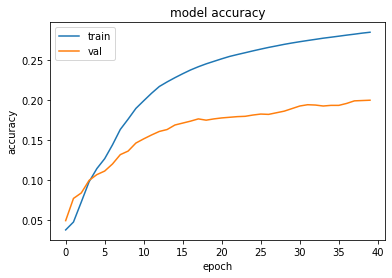

In [0]:
from matplotlib import pyplot as plt

plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

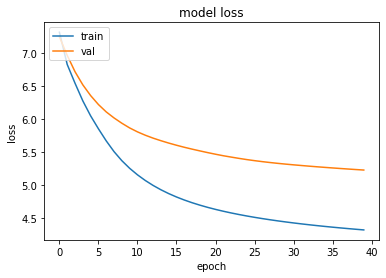

In [0]:
from matplotlib import pyplot as plt

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

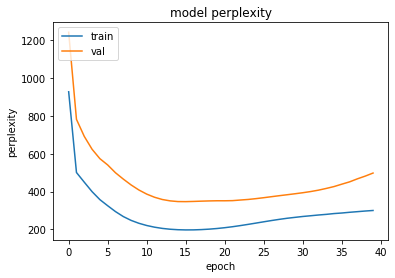

In [0]:
from matplotlib import pyplot as plt

plt.plot(history['perplexity'])
plt.plot(history['val_perplexity'])
plt.title('model perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

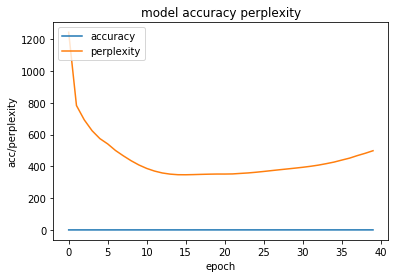

In [0]:
from matplotlib import pyplot as plt

plt.plot(history['val_acc'])
plt.plot(history['val_perplexity'])
plt.title('model accuracy perplexity')
plt.ylabel('acc/perplexity')
plt.xlabel('epoch')
plt.legend(['accuracy', 'perplexity'], loc='upper left')
plt.show()

In [0]:
# data = """ Jack and Jill went up the hill\n
# To fetch a pail of water\n
# Jack fell down and broke his crown\n
# And Jill came tumbling after\n """
# # integer encode sequences of words
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts([data])
# encoded = tokenizer.texts_to_sequences([data])[0]

In [0]:

# vocab_size = len(tokenizer.word_index) + 1
# print('Vocabulary Size: %d' % vocab_size)
# # create line-based sequences
# sequences = list()
# for line in data.split('\n'):
#     encoded = tokenizer.texts_to_sequences([line])[0]
#     for i in range(1, len(encoded)):
#         sequence = encoded[:i+1]
#         sequences.append(sequence)

# print('Total Sequences: %d' % len(sequences))

In [0]:
# sequences

In [0]:
# # pad input sequences
# max_length = max([len(seq) for seq in sequences])
# sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
# print('Max Sequence Length: %d' % max_length)
# # split into input and output elements
# sequences = array(sequences)
# X, y = sequences[:,:-1],sequences[:,-1]
# y = to_categorical(y, num_classes=vocab_size)

In [0]:
# X

In [0]:
# y